In [1]:
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.layers import Input,Dense,concatenate,Dropout,Conv1D,Bidirectional,LSTM,SimpleRNN
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
def plot_series(time, series, format="-", start=0, end=None, Title='Time Series Plot'):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.title(Title)

In [3]:
#Daily minimum temperatures in Melbourne, Australia, 1981-1990  (credit to jbrownlee)
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-10-26 12:25:36--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2021-10-26 12:25:37 (7.56 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [4]:
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

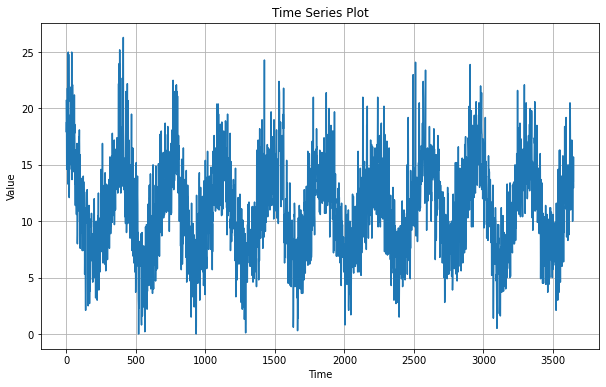

In [5]:
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [7]:
data={'time step':time,'temps':series}
df=pd.DataFrame(data=data)

In [8]:
df.head()

,time step,temps
0,0,20.7
1,1,17.9
2,2,18.8
3,3,14.6
4,4,15.8


In [9]:
df=df.set_index("time step")
df.head()

,temps
time step,
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


In [10]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temps" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4448
 No. Lags Chosen       = 20
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.




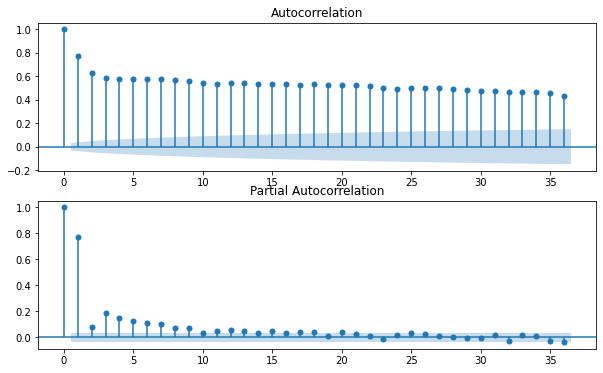

In [11]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0]=plot_acf(df.temps,ax=ax[0])
ax[1]=plot_pacf(df.temps,ax=ax[1])

In [12]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [13]:
def windowed_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
tf.random.set_seed(123)
np.random.seed(123)
window_size=5

In [16]:
train_set = windowed_dataset(x_train, window_size, batch_size=1)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


2021-10-26 12:25:39.276369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 12:25:39.359043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 12:25:39.359820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 12:25:39.363026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
valid_set = windowed_dataset(x_valid, window_size, batch_size=1)
print(valid_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1150,)


## LSTM

In [18]:
inputs=Input(shape=(None,1))
layer=LSTM(100)(inputs)
layer=Dense(5,activation='relu')(layer)
output=Dense(1)(layer)

model=Model(inputs=[inputs], outputs=[output])
adam=Adam(learning_rate=0.001, decay=1e-5)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae','mse'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 41,311
Trainable params: 41,311
Non-trainable params: 0
_________________________________________________________________


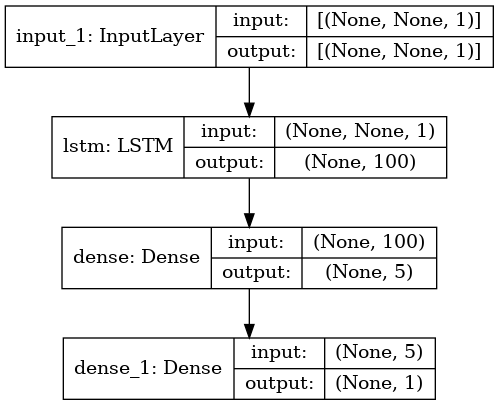

In [20]:
plot_model(model, to_file='LSTM model.png', show_shapes=True)

In [21]:
history=model.fit(train_set, epochs=25, validation_data=valid_set)

2021-10-26 12:25:43.232459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-10-26 12:25:45.621641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2495/2495 [==============================] - 16s 5ms/step - loss: 12.3239 - mae: 2.3621 - mse: 12.3239 - val_loss: 6.6649 - val_mae: 2.0666 - val_mse: 6.6649
Epoch 2/25
2495/2495 [==============================] - 12s 5ms/step - loss: 5.2051 - mae: 1.7730 - mse: 5.2051 - val_loss: 5.3063 - val_mae: 1.8139 - val_mse: 5.3063
Epoch 3/25
2495/2495 [==============================] - 12s 5ms/step - loss: 5.0543 - mae: 1.7449 - mse: 5.0543 - val_loss: 5.0651 - val_mae: 1.7664 - val_mse: 5.0651
Epoch 4/25
2495/2495 [==============================] - 12s 5ms/step - loss: 4.9754 - mae: 1.7300 - mse: 4.9754 - val_loss: 4.9531 - val_mae: 1.7436 - val_mse: 4.9531
Epoch 5/25
2495/2495 [==============================] - 13s 5ms/step - loss: 4.9320 - mae: 1.7217 - mse: 4.9320 - val_loss: 4.8046 - val_mae: 1.7112 - val_mse: 4.8046
Epoch 6/25
2495/2495 [==============================] - 12s 5ms/step - loss: 4.9033 - mae: 1.7163 - mse: 4.9033 - val_loss: 4.6878 - val_mae: 1.6851 - val_mse: 4.6878
Epoch 7

<Figure size 432x288 with 0 Axes>

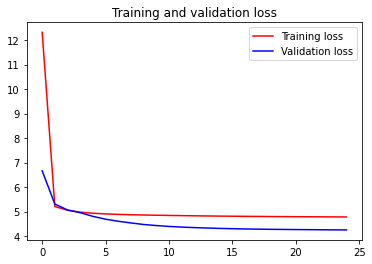

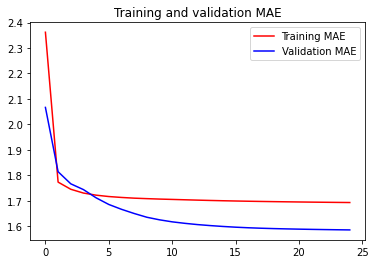

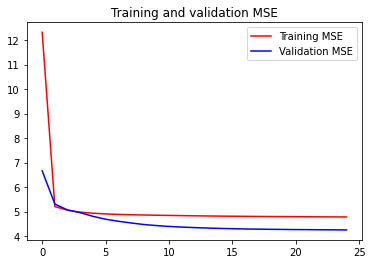

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']
mae=history.history['mae']
val_mae=history.history['val_mae']
mse=history.history['mse']
val_mse=history.history['val_mse']

epochs=range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mae, 'r', label = 'Training MAE')
plt.plot(epochs, val_mae, 'b', label ='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

plt.plot(epochs, mse, 'r', label = 'Training MSE')
plt.plot(epochs, val_mse, 'b', label ='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.figure()

In [23]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size, batch_size=1)
lstm_forecast = lstm_forecast[split_time - window_size:-1, 0]

In [24]:
lstm_forecast.shape

(1150,)

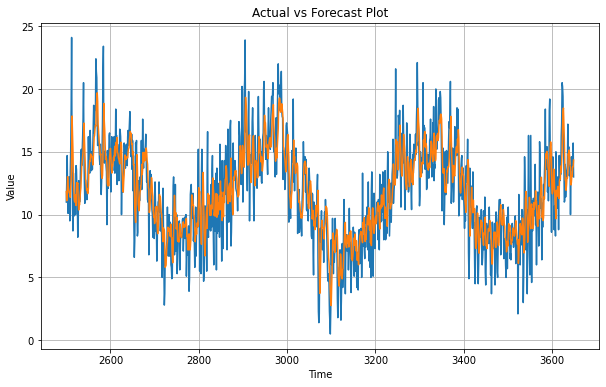

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast, Title="Actual vs Forecast Plot")

In [26]:
#Simpan model
model.save("LSTM Time Series.h5")

In [27]:
#Memuat (load) model 
model=load_model("LSTM Time Series.h5")

## Bidirectional LSTM

In [28]:
inputs=Input(shape=(None,1))
layer=Bidirectional(LSTM(100))(inputs)
layer=Dense(5,activation='relu')(layer)
output=Dense(1)(layer)

model2=Model(inputs=[inputs], outputs=[output])
adam=Adam(learning_rate=0.001, decay=1e-5)

model2.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae','mse'])

In [29]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               81600     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 82,611
Trainable params: 82,611
Non-trainable params: 0
_________________________________________________________________


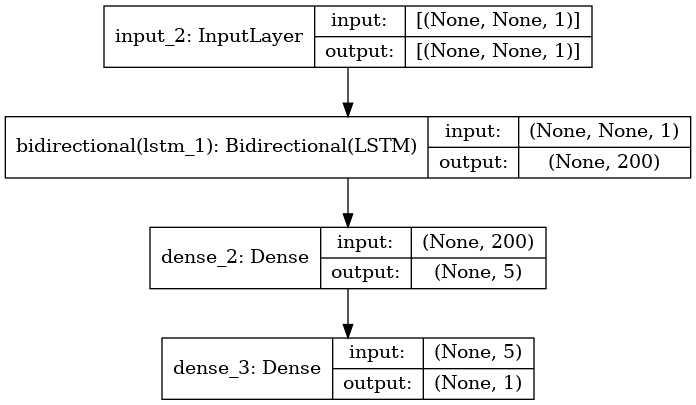

In [30]:
plot_model(model2, to_file='Bi-LSTM model.png', show_shapes=True)

In [31]:
history2=model2.fit(train_set, epochs=25, validation_data=valid_set)

Epoch 1/25
2495/2495 [==============================] - 22s 8ms/step - loss: 8.7221 - mae: 2.1053 - mse: 8.7221 - val_loss: 6.4989 - val_mae: 2.0221 - val_mse: 6.4989
Epoch 2/25
2495/2495 [==============================] - 18s 7ms/step - loss: 5.3000 - mae: 1.7878 - mse: 5.3000 - val_loss: 5.1756 - val_mae: 1.7744 - val_mse: 5.1756
Epoch 3/25
2495/2495 [==============================] - 17s 7ms/step - loss: 5.0779 - mae: 1.7476 - mse: 5.0779 - val_loss: 5.0017 - val_mae: 1.7438 - val_mse: 5.0017
Epoch 4/25
2495/2495 [==============================] - 17s 7ms/step - loss: 4.9911 - mae: 1.7311 - mse: 4.9911 - val_loss: 4.8303 - val_mae: 1.7076 - val_mse: 4.8303
Epoch 5/25
2495/2495 [==============================] - 20s 8ms/step - loss: 4.9479 - mae: 1.7226 - mse: 4.9479 - val_loss: 4.6985 - val_mae: 1.6799 - val_mse: 4.6985
Epoch 6/25
2495/2495 [==============================] - 16s 7ms/step - loss: 4.9193 - mae: 1.7173 - mse: 4.9193 - val_loss: 4.5862 - val_mae: 1.6566 - val_mse: 4.586

<Figure size 432x288 with 0 Axes>

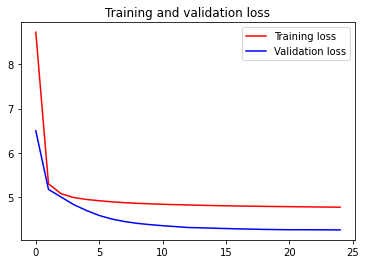

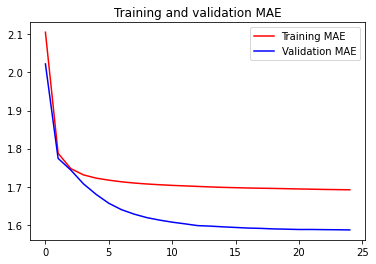

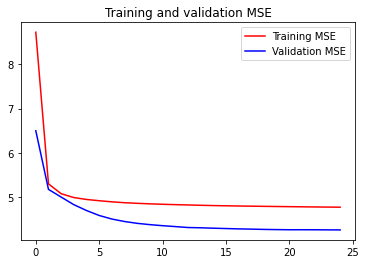

<Figure size 432x288 with 0 Axes>

In [32]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history2.history['loss']
val_loss=history2.history['val_loss']
mae=history2.history['mae']
val_mae=history2.history['val_mae']
mse=history2.history['mse']
val_mse=history2.history['val_mse']

epochs=range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mae, 'r', label = 'Training MAE')
plt.plot(epochs, val_mae, 'b', label ='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

plt.plot(epochs, mse, 'r', label = 'Training MSE')
plt.plot(epochs, val_mse, 'b', label ='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.figure()

In [33]:
bilstm_forecast = model_forecast(model2, series[..., np.newaxis], window_size, batch_size=1)
bilstm_forecast = bilstm_forecast[split_time - window_size:-1, 0]

In [34]:
bilstm_forecast.shape

(1150,)

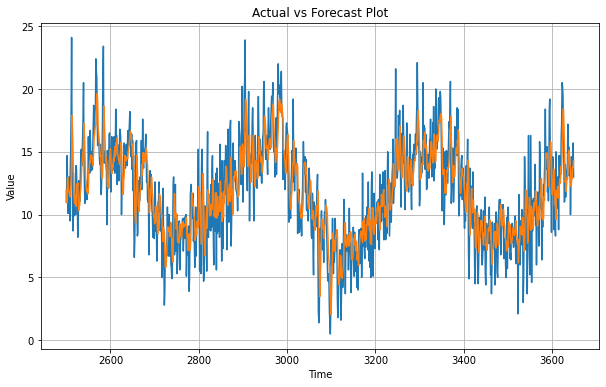

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, bilstm_forecast, Title="Actual vs Forecast Plot")

In [36]:
#Simpan model
model2.save("Bi-LSTM Time Series.h5")

In [37]:
#Memuat (load) model 
model2=load_model("Bi-LSTM Time Series.h5")